# Imports and setup

In [1]:
from torch import nn, optim
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from facenet_pytorch import InceptionResnetV1
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
import matplotlib.pyplot as plt
import os

from pytorch_metric_learning.miners import BatchHardMiner
from pytorch_metric_learning.losses import TripletMarginLoss

import lpips
import time




/home/e20220005499/Documents/Face-Swap-M2/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import utils
import dataloader

### Check si on peut utiliser cuda

In [3]:
print("Cuda compatible : ", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda compatible :  True


### classe pour mesurer le temps d'entrainement restant

In [4]:
class ETA:
    t = []
    @staticmethod
    def fmt(s):
        s=int(s);m,s=divmod(s,60);h,m=divmod(m,60)
        return f"{h}h {m}m {s}s" if h else f"{m}m {s}s" if m else f"{s}s"

    def __init__(self,total,win=50):
        self.total=total;self.win=win;self.step=0

    def update(self):
        ETA.t.append(time.time())
        ETA.t=ETA.t[-self.win:]
        self.step+=1

    def eta(self):
        if self.step<2:return 0
        d=[ETA.t[i]-ETA.t[i-1] for i in range(1,len(ETA.t))]
        return (self.total-self.step)*(sum(d)/len(d))
    def print(self):
        print(ETA.fmt(self.eta()))


# Chargement du dataset

In [5]:
IMAGE_SIZE = 128
NB_IMAGES = 10

In [6]:
train_dataset, test_dataset, nb_classes = dataloader.make_dataset("../data/Face-Swap-M2-Dataset/dataset/smaller", NB_IMAGES, IMAGE_SIZE, 0.8, crop_faces=True)


Building dataset 



# Data Augmentation

In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)
])

class TransformedTensorDataset(Dataset):
    def __init__(self, tensor_dataset, transform=None):
        self.dataset = tensor_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

train_dataset = TransformedTensorDataset(train_dataset, transform=data_transform)
test_dataset = TransformedTensorDataset(test_dataset, transform=None)


# Paramètres

In [8]:

EMBEDDING_SIZE = 128
BATCH_SIZE = 32

EPOCHS = 100

In [9]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
for images, labels in train_loader:
    print("Batch shape:", images.shape)
    print("Min pixel value:", images.min().item())
    print("Max pixel value:", images.max().item())
    print("Mean pixel value:", images.mean().item())
    break

Batch shape: torch.Size([32, 3, 128, 128])
Min pixel value: -0.94921875
Max pixel value: 0.97265625
Mean pixel value: -0.13575051724910736


train samples: 65, test samples: 19, nb_classes: 10
train Class 0: 8 samples
train Class 1: 6 samples
train Class 2: 7 samples
train Class 3: 5 samples
train Class 4: 4 samples
train Class 5: 7 samples
train Class 6: 8 samples
train Class 7: 7 samples
train Class 8: 8 samples
train Class 9: 5 samples
Test Class 0: 2 samples
Test Class 1: 2 samples
Test Class 2: 2 samples
Test Class 3: 2 samples
Test Class 4: 1 samples
Test Class 5: 2 samples
Test Class 6: 2 samples
Test Class 7: 2 samples
Test Class 8: 2 samples
Test Class 9: 2 samples


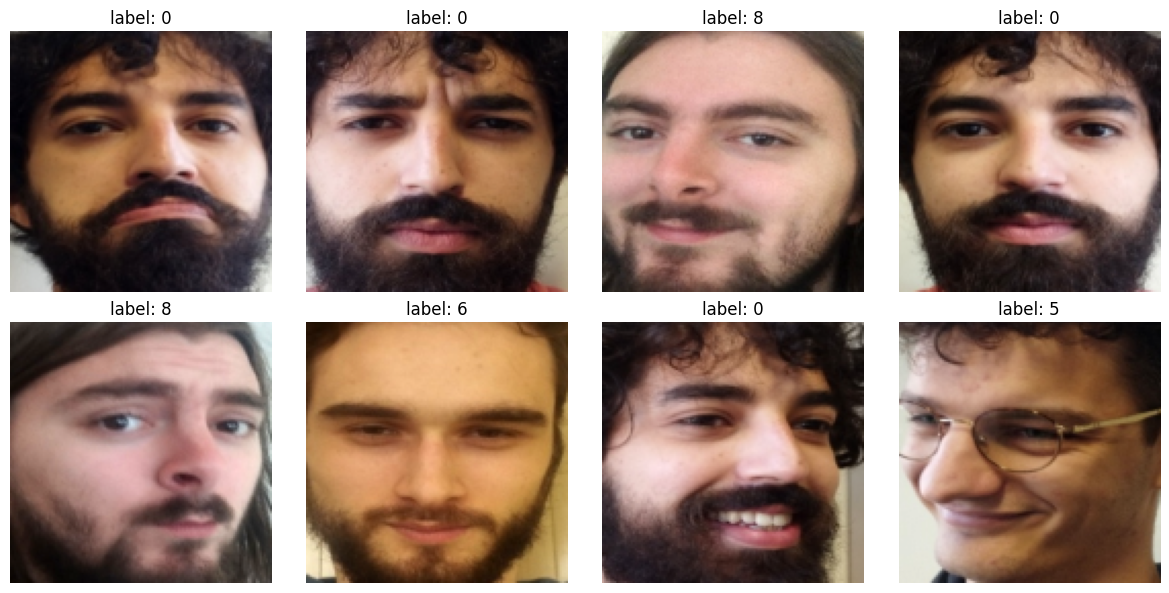

In [11]:
print(f"train samples: {len(train_dataset)}, test samples: {len(test_dataset)}, nb_classes: {nb_classes}")

class_counts = np.bincount([label for _, label in train_dataset])
for cls, count in enumerate(class_counts):
    print(f"train Class {cls}: {count} samples")

class_counts = np.bincount([label for _, label in test_dataset])
for cls, count in enumerate(class_counts):
    print(f"Test Class {cls}: {count} samples")

images, labels = next(iter(train_loader))
images = images.cpu()
labels = labels.cpu().numpy()

n = min(8, images.size(0))
imgs = images[:n]
labs = labels[:n]

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i, ax in enumerate(axs):
    if i < n:
        img = imgs[i].permute(1, 2, 0).numpy()
        mi, ma = img.min(), img.max()
        img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
        ax.imshow(img_disp)
        ax.set_title(f"label: {labs[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Définition des modèles

In [12]:


class Embedder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1), # 3 car image RGB, 6 en sortie (6 filtres) , taille noyau de 5
            nn.BatchNorm2d(8), # empeche le collapse des embeddings
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # reduit par 2 la taille
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Linear(16 *32*32, EMBEDDING_SIZE )

    def forward(self,x):
        res = self.conv(x)
        res = torch.flatten(res,1)
        res = self.fc(res)
        res = res / res.norm(dim= 1, keepdim=True).clamp(min=1e-6) # normalise la sortie, donne de meilleur resultat
        return res


class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc = nn.Linear(EMBEDDING_SIZE, num_classes)
    def forward(self, x):
        return self.fc(x)
    

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(EMBEDDING_SIZE, 128, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),

        )

    def forward(self, x):
        res = x.unflatten(1, (EMBEDDING_SIZE, 1, 1))
        res = self.decoder(res)
        return res




# Embedding

## Entrainement

In [13]:
faceEmbedder = Embedder().to(device)

model_parameters = filter(lambda p: p.requires_grad, faceEmbedder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Embedder has {params} parameters")

triplet_loss = TripletMarginLoss(margin=1.0)
miner = BatchHardMiner()
optimizer = optim.Adam(faceEmbedder.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

final_embedder_loss = 0.0

train_losses = []
val_losses = []

faceEmbedder.train()
for epoch in range(200):

    total_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        #anchor_idx, positive_idx, negative_idx = utils.get_triplets(labels)
        #anchors = output[anchor_idx]
        #positives = output[positive_idx]
        #negatives = output[negative_idx]
        #loss = triplet_loss(anchors, positives, negatives)

        triplets = miner(output, labels)

        loss = triplet_loss(output,labels, triplets)

        
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    total_loss = total_loss / len(train_loader)
    train_losses.append(total_loss)

    faceEmbedder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = faceEmbedder(images)
            #anchor_idx, positive_idx, negative_idx = utils.get_triplets(labels)

            #anchors = output[anchor_idx]
            #positives = output[positive_idx]
            #negatives = output[negative_idx]
            #loss = triplet_loss(anchors, positives, negatives)

            triplets = miner(output, labels)

            loss = triplet_loss(output,labels, triplets)

            val_loss += loss.item()

    val_loss = val_loss / len(test_loader)
    #val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}")
    final_embedder_loss = total_loss
    faceEmbedder.train()


Embedder has 2098720 parameters
Epoch 1, Training Loss: 0.7558, Validation Loss: 1.0004
Epoch 2, Training Loss: 0.7251, Validation Loss: 1.0029
Epoch 3, Training Loss: 0.6826, Validation Loss: 0.9946
Epoch 4, Training Loss: 0.6873, Validation Loss: 0.9875
Epoch 5, Training Loss: 0.6667, Validation Loss: 0.9845
Epoch 6, Training Loss: 0.6668, Validation Loss: 0.9779
Epoch 7, Training Loss: 0.6565, Validation Loss: 0.9710
Epoch 8, Training Loss: 0.6408, Validation Loss: 0.9664
Epoch 9, Training Loss: 0.6359, Validation Loss: 0.9583
Epoch 10, Training Loss: 0.6246, Validation Loss: 0.9467
Epoch 11, Training Loss: 0.6092, Validation Loss: 0.9356
Epoch 12, Training Loss: 0.6085, Validation Loss: 0.9238
Epoch 13, Training Loss: 0.5957, Validation Loss: 0.9116
Epoch 14, Training Loss: 0.5773, Validation Loss: 0.9000
Epoch 15, Training Loss: 0.5667, Validation Loss: 0.8889
Epoch 16, Training Loss: 0.5491, Validation Loss: 0.8795
Epoch 17, Training Loss: 0.5254, Validation Loss: 0.8689
Epoch 18

In [ ]:
torch.save(faceEmbedder.state_dict(), f"embedder_150.pth")

## Analyse

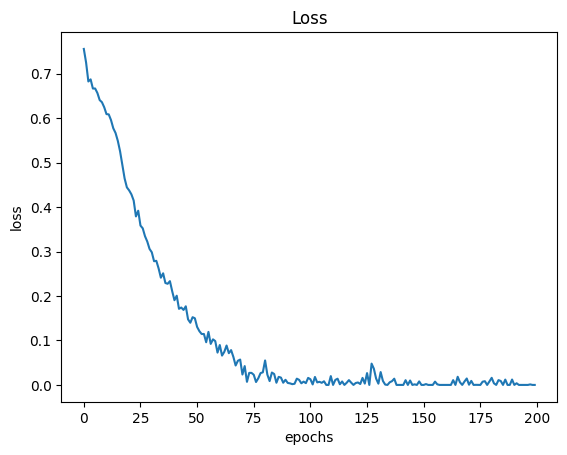

In [14]:
plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Calcul tous les embeddings

In [15]:
faceEmbedder.eval()
embeddings = []
avg_embeddings = []
with torch.no_grad():
    for images, labels in train_loader:
        #print(labels)
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        for i in range(output.size(0)):
            embeddings.append([output[i].cpu().tolist(), labels[i].cpu().item()])

    emb_np = np.array([item[0] for item in embeddings])
    lab_np = np.array([item[1] for item in embeddings])



    for cls in range(nb_classes):
        idx = np.where(lab_np == cls)[0]
        avg_emb = emb_np[idx].mean(axis=0)

        avg_embeddings.append(avg_emb)

        print(f"classe {cls}: avg embedding = {avg_emb.tolist()}")

classe 0: avg embedding = [0.007848910376196727, 0.036481936695054173, 0.008163988575688563, -0.08802380645647645, 0.04003356653265655, 0.11954110115766525, -0.17544644325971603, 0.10563495848327875, 0.11080736108124256, -0.04496291698887944, 0.04960928694345057, 0.08982129860669374, 0.021585199574474245, -0.1333285178989172, -0.10397758334875107, -0.07623532833531499, -0.11251870077103376, 0.0450746042188257, -0.07837818283587694, -0.19853253103792667, 0.07433106703683734, 0.04129354748874903, 0.1322029046714306, -0.03803542716195807, 0.10296341963112354, 0.04561852337792516, 0.06255437759682536, 0.028208921779878438, 0.012161774910055101, 0.08437408693134785, 0.09526561386883259, 0.07507407246157527, 0.07511625881306827, -0.07607857463881373, -0.1019346909597516, -0.009198336163535714, -0.04882572218775749, 0.08787733688950539, -0.10181433521211147, -0.03931241889949888, 0.07369563495740294, -0.024600691627711058, -0.026603350648656487, -0.006714658346027136, 0.06861517578363419, 0.0

In [16]:
import math

faceEmbedder.eval()

correct = 0
total = 0
avg_embeddings = torch.Tensor(avg_embeddings).to(device)

with torch.no_grad():
    for images, labels in DataLoader(test_dataset, batch_size=1):
        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        min_dist = math.inf
        i_min = -1
        for i in range(len(avg_embeddings)):
            d = torch.dist(output[0], avg_embeddings[i])
            if d.item() < min_dist:
                i_min = i
                min_dist = d.item()

        if i_min == labels[0].item():
            correct += 1

        total += labels.size(0)

accuracy = correct / total if total > 0 else 0.0 
print(f"accuracy: {accuracy:.4f}, {correct} / {total}")


accuracy: 0.9474, 18 / 19


/tmp/ipykernel_12346/3697995146.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  avg_embeddings = torch.Tensor(avg_embeddings).to(device)


### Plot embeddings

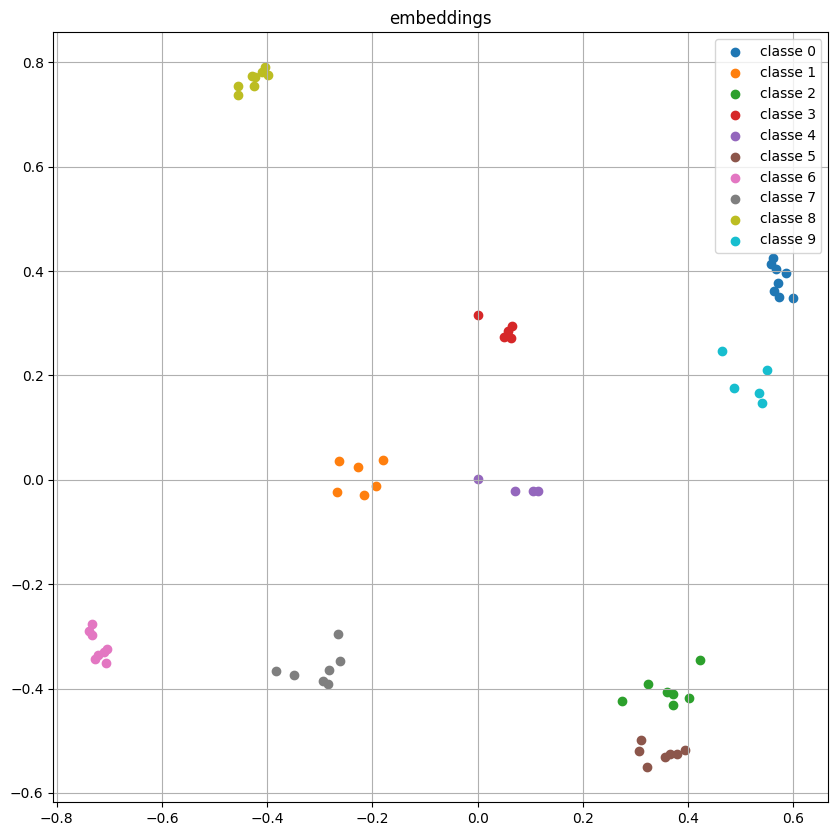

In [17]:
def plot_embeddings():
    embeddings_np = np.array([e[0] for e in embeddings])
    labels_np = np.array([e[1] for e in embeddings])

    pca = PCA(n_components=2) #reduction en 2D
    reduced_embeddings = pca.fit_transform(embeddings_np)

    plt.figure(figsize=(10, 10))
    for label in np.unique(labels_np):
        idx = labels_np == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"classe {label}")

    plt.title("embeddings")
    plt.legend()
    plt.grid(True)
    plt.show()



plot_embeddings()

# Classifieur

## Entrainement

In [18]:

classifier = Classifier(nb_classes).to(device)
crossLoss = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.0005)

final_classifier_loss = [0.0,0.0]

losses = []

faceEmbedder.eval()
for epoch in range(1000):
    total_loss = 0.0
    classifier.train()
    for images, labels in train_loader:
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = classifier(embeded)
        loss = crossLoss(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    #test avec le set de validation
    classifier.eval()
    total_eval_loss = 0.0
    for images, labels in test_loader:
        #images = torch.flatten(images, 1)
        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = classifier(embeded)
        loss = crossLoss(output, labels)

        #metrics
        total_eval_loss += loss.item()


    total_loss = total_loss / len(train_loader)
    total_eval_loss = total_eval_loss / len(test_loader)
    print(f"Epoch {epoch+1}, training loss: {total_loss:.4f}, test loss: {total_eval_loss:.4f}")

    losses.append((total_loss, total_eval_loss))

    final_classifier_loss[0] = total_loss
    final_classifier_loss[1] = total_eval_loss



#print("Classifier final train loss : ", final_classifier_loss[0], " test loss : ", final_classifier_loss[1])

Epoch 1, training loss: 2.2814, test loss: 2.2979
Epoch 2, training loss: 2.2666, test loss: 2.2903
Epoch 3, training loss: 2.2658, test loss: 2.2829
Epoch 4, training loss: 2.2468, test loss: 2.2758
Epoch 5, training loss: 2.2422, test loss: 2.2688
Epoch 6, training loss: 2.2260, test loss: 2.2619
Epoch 7, training loss: 2.2621, test loss: 2.2549
Epoch 8, training loss: 2.2073, test loss: 2.2481
Epoch 9, training loss: 2.1992, test loss: 2.2415
Epoch 10, training loss: 2.1869, test loss: 2.2350
Epoch 11, training loss: 2.2019, test loss: 2.2286
Epoch 12, training loss: 2.1924, test loss: 2.2221
Epoch 13, training loss: 2.1603, test loss: 2.2156
Epoch 14, training loss: 2.2169, test loss: 2.2092
Epoch 15, training loss: 2.1438, test loss: 2.2029
Epoch 16, training loss: 2.1907, test loss: 2.1967
Epoch 17, training loss: 2.1591, test loss: 2.1903
Epoch 18, training loss: 2.1696, test loss: 2.1839
Epoch 19, training loss: 2.1354, test loss: 2.1776
Epoch 20, training loss: 2.1231, test lo

## Analyse

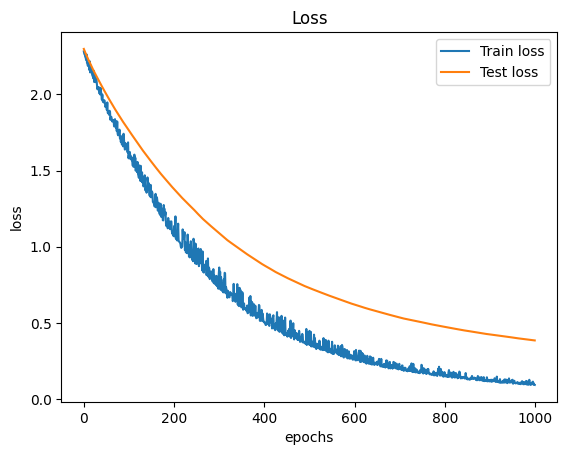

In [19]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

### Plot la matrice de confusion et accuracy

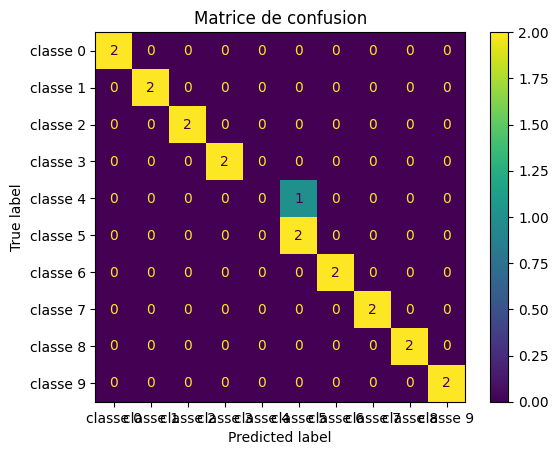

accuracy on test set: 94.74% (18/19)


In [20]:
def plot_confusion_matrix():
    classifier.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            #images = torch.flatten(images, 1)
            images = images.to(device)
            labels = labels.to(device)

            embeded = faceEmbedder(images)
            output = classifier(embeded)
            predictions = torch.argmax(output, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions, labels=range(nb_classes))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"classe {i}" for i in range(nb_classes)])
    disp.plot()
    plt.title("Matrice de confusion")
    plt.show()

plot_confusion_matrix()


classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        #images = torch.flatten(images, 1).to(device)
        images = images.to(device)
        labels = labels.to(device)
        logits = classifier(faceEmbedder(images))
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total if total > 0 else 0.0
print(f"accuracy on test set: {accuracy * 100:.2f}% ({correct}/{total})")

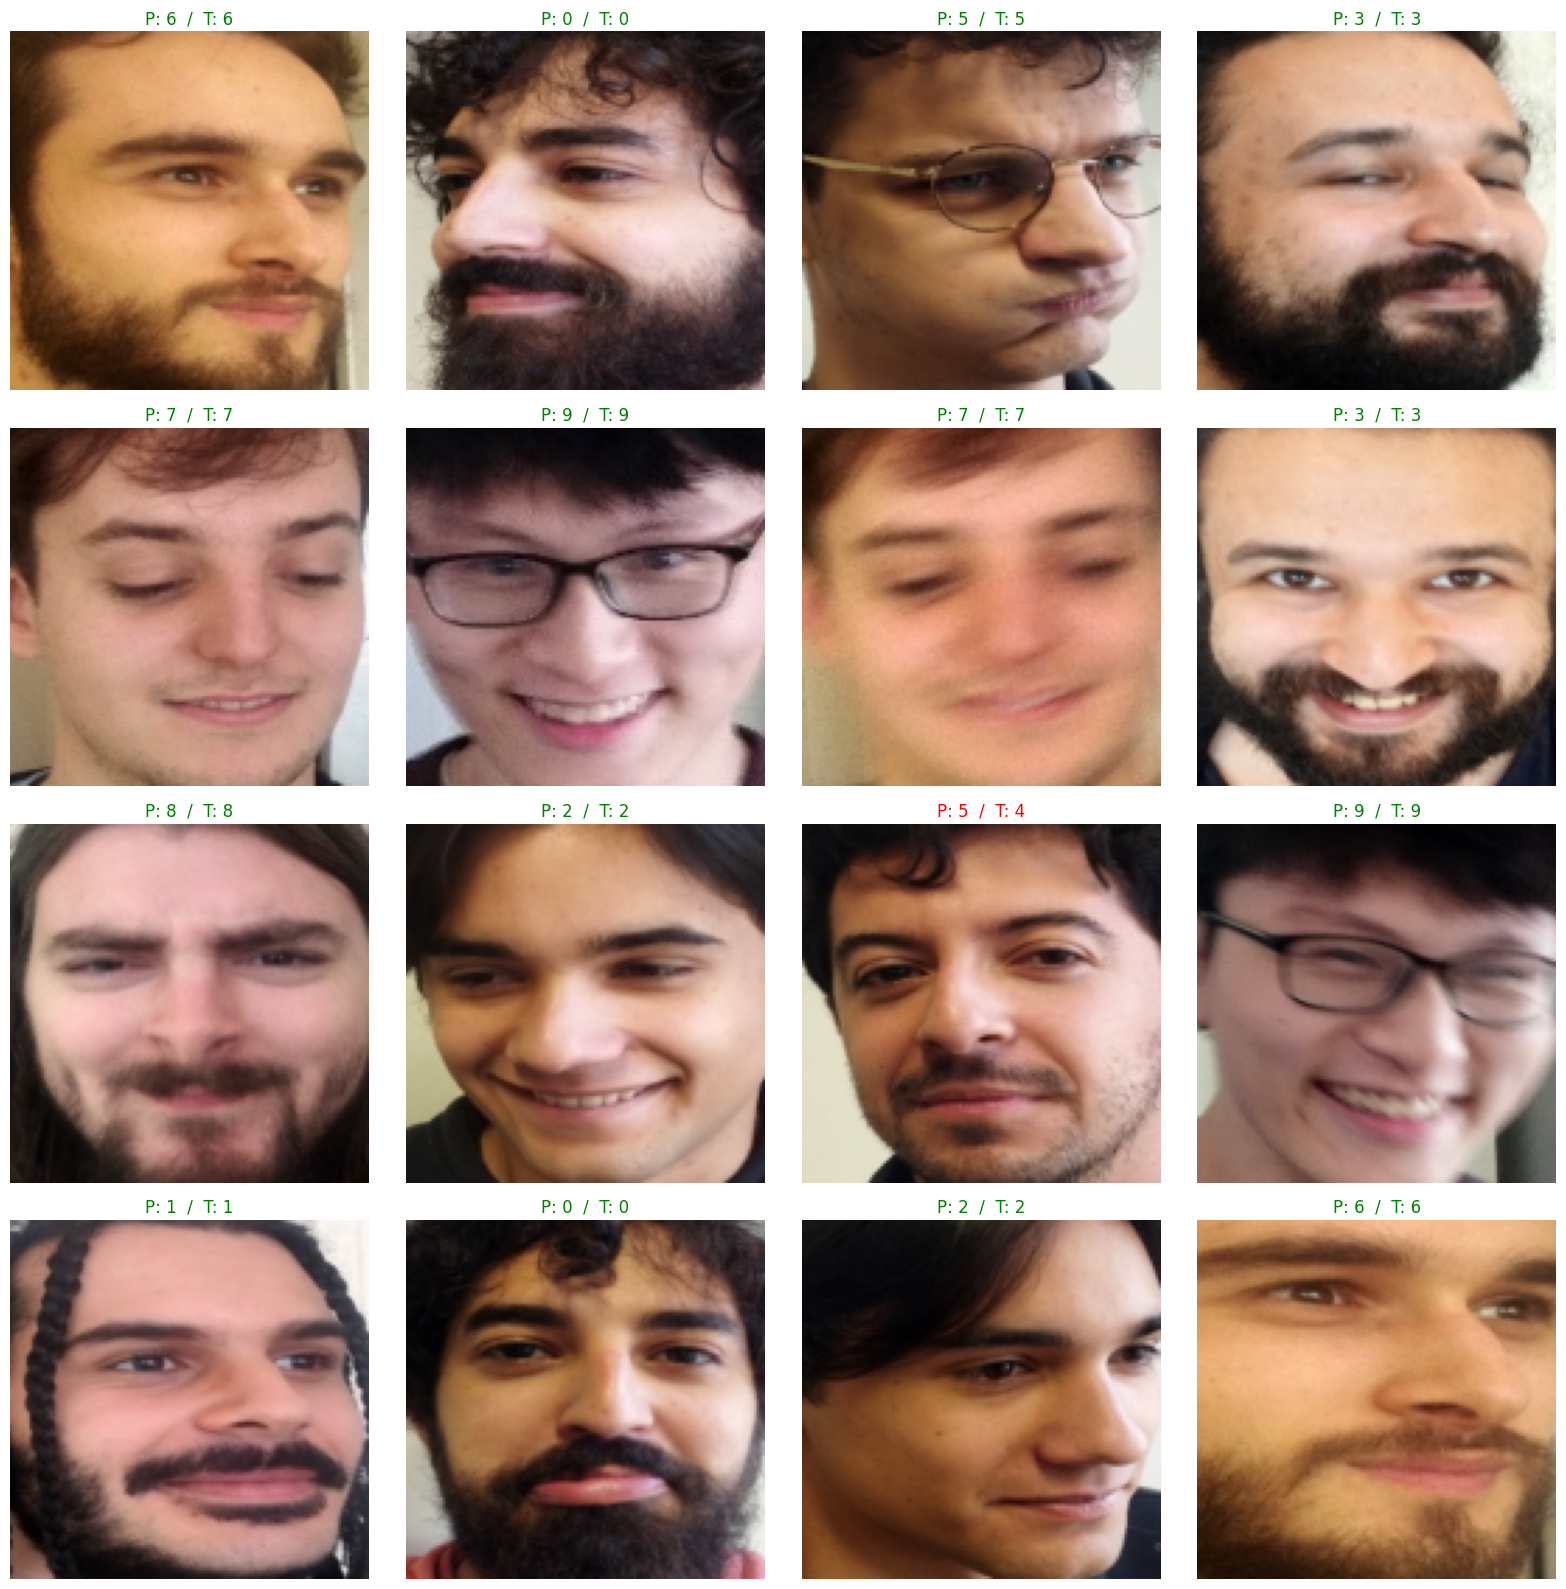

In [21]:
import math

faceEmbedder.eval()
classifier.eval()

num_display = 16 
cols = 4
rows = math.ceil(num_display / cols)

imgs_to_show = []
trues = []
preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images_cpu = images.cpu()
        images_dev = images.to(device)
        labels_dev = labels.to(device)

        embeddings = faceEmbedder(images_dev)
        logits = classifier(embeddings)
        batch_preds = logits.argmax(dim=1).cpu().numpy()
        batch_labels = labels_dev.cpu().numpy()

        for i in range(images_cpu.size(0)):
            imgs_to_show.append(images_cpu[i].permute(1, 2, 0).numpy())
            trues.append(int(batch_labels[i]))
            preds.append(int(batch_preds[i]))
            if len(imgs_to_show) >= num_display:
                break
        if len(imgs_to_show) >= num_display:
            break

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.axis("off")
    if i < len(imgs_to_show):
        img = imgs_to_show[i]
        mi, ma = img.min(), img.max()
        denom = (ma - mi) if (ma - mi) > 1e-6 else 1.0
        img_disp = (img - mi) / denom
        ax.imshow(img_disp)
        true = trues[i]
        pred = preds[i]
        color = "green" if pred == true else "red"
        ax.set_title(f"P: {pred}  /  T: {true}", color=color, fontsize=12)
plt.tight_layout()
plt.show()

# VAE

In [55]:

EMBEDDING_SIZE = 256

class ResBlock(nn.Module):
    """Residual block for better gradient flow"""
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
        )
    
    def forward(self, x):
        return F.relu(x + self.conv(x))

class VAE(nn.Module):
    def __init__(self, embedding=128, img_size=128):
        super().__init__()
        self.embedding = embedding
        self.img_size = img_size
        
        # Calculate bottleneck size: 128 -> 64 -> 32 -> 16 -> 8
        self.bottleneck_size = img_size // 16  # = 8 for 128x128 images
        self.bottleneck_channels = 256
        self.flattened_size = self.bottleneck_channels * self.bottleneck_size * self.bottleneck_size

        # ---------- Encoder ----------
        self.encoder = nn.Sequential(
            # 128x128 -> 64x64
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            # 64x64 -> 32x32
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            ResBlock(64),
            
            # 32x32 -> 16x16
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            ResBlock(128),
            
            # 16x16 -> 8x8
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            ResBlock(256),
        )

        # ---------- Latent space ----------
        self.fc_mu = nn.Linear(self.flattened_size, embedding)
        self.fc_logvar = nn.Linear(self.flattened_size, embedding)
        
        # ---------- Decoder ----------
        self.fc_decode = nn.Linear(embedding, self.flattened_size)
        
        self.decoder = nn.Sequential(
            ResBlock(256),
            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            ResBlock(128),
            
            # 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ResBlock(64),
            
            # 32x32 -> 64x64
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # 64x64 -> 128x128
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # Final refinement
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def encode(self, x):
        h = self.encoder(x)
        h = torch.flatten(h, 1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mean

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, self.bottleneck_channels, self.bottleneck_size, self.bottleneck_size)
        return self.decoder(h)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparametrize(mean, logvar)
        recon = self.decode(z)
        return z, recon, mean, logvar
    
    def random(self, n=1):
        z = torch.randn((n, self.embedding), device=next(self.parameters()).device)
        return z, self.decode(z)


## Entrainement autoencoder complet

In [81]:
autoencoder = VAE(embedding=EMBEDDING_SIZE, img_size=IMAGE_SIZE).to(device)

losses = []

# Optional: perceptual loss for sharper images
use_perceptual = True
if use_perceptual:
    lpipsLoss = lpips.LPIPS(net='alex').to(device)
    lpips_factor = 0.1

optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

model_parameters = filter(lambda p: p.requires_grad, autoencoder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"VAE has {params:,} parameters")

# Beta-VAE: start with low beta to focus on reconstruction, then increase
beta_start = 0.0001
beta_end = 1.0
beta_anneal_epochs = 100  # Linearly increase beta over this many epochs

def elbo_loss(recon, x, mean, logvar, beta):
    # Reconstruction loss (per pixel, summed over image, averaged over batch)
    recon_loss = F.mse_loss(recon, x, reduction='sum') / x.size(0)
    
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / x.size(0)
    
    # Optional perceptual loss
    perc_loss = 0
    if use_perceptual:
        perc_loss = lpipsLoss(recon, x).mean() * lpips_factor
    
    total = recon_loss + beta * kl_loss + perc_loss
    return total, recon_loss, kl_loss

print("Starting training...")


VAE has 10,807,299 parameters
Starting training...


/home/e20220005499/Documents/Face-Swap-M2/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Optional: Load a previously saved model
# checkpoint_path = "vae_best.pth"
# if os.path.exists(checkpoint_path):
#     autoencoder.load_state_dict(torch.load(checkpoint_path))
#     print(f"Loaded checkpoint from {checkpoint_path}")
# autoencoder.eval()


In [57]:
epochs = 300

eta = ETA(epochs)
best_val_loss = float('inf')

for epoch in range(epochs):
    eta.update()
    
    # Beta annealing: gradually increase KL weight
    if epoch < beta_anneal_epochs:
        beta = beta_start + (beta_end - beta_start) * (epoch / beta_anneal_epochs)
    else:
        beta = beta_end
    
    # Training
    autoencoder.train()
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        
        optimizer.zero_grad()
        z, recon, mean, logvar = autoencoder(images)
        loss, recon_loss, kl_loss = elbo_loss(recon, images, mean, logvar, beta)
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()

    # Validation
    autoencoder.eval()
    total_eval_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            z, recon, mean, logvar = autoencoder(images)
            loss, _, _ = elbo_loss(recon, images, mean, logvar, beta)
            total_eval_loss += loss.item()

    # Average losses
    train_loss = total_loss / len(train_loader)
    train_recon = total_recon / len(train_loader)
    train_kl = total_kl / len(train_loader)
    val_loss = total_eval_loss / len(test_loader)
    
    # Learning rate schedulingesBlocks added for better gradient flow and feature 
    scheduler.step(val_loss)
    
    losses.append((train_loss, val_loss))
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(autoencoder.state_dict(), "vae_best.pth")
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train: {train_loss:.2f} (R:{train_recon:.2f}, KL:{train_kl:.2f}) | Val: {val_loss:.2f} | β:{beta:.4f} | ETA: {eta.fmt(eta.eta())}")

print(f"\nTraining complete! Best validation loss: {best_val_loss:.4f}")


NameError: name 'meanimages' is not defined

### Analyse

#### Loss

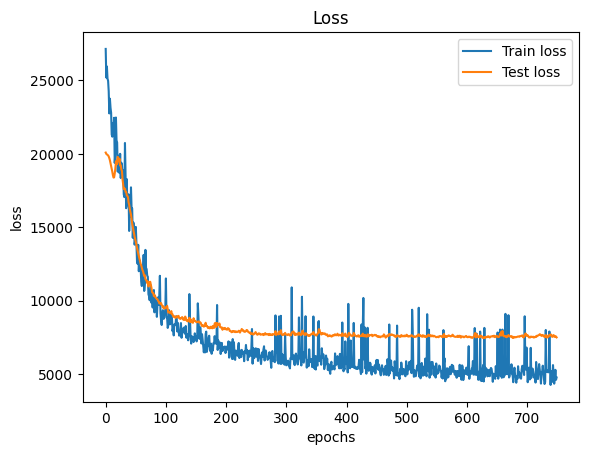

In [51]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

#### Encoder

classe 0: avg embedding = [0.17860810086131096, 0.44473419338464737, 0.42145902663469315, 0.8796574845910072, 0.9993600025773048, -2.15759813785553, 1.5282288994640112, -0.33786267414689064, -0.6783453393727541, 2.188238875940442, 0.4890833767130971, -0.8995896577835083, 1.2976968958973885, 0.4280093898996711, 1.498434066772461, 2.522142857313156, 0.17593473196029663, 0.7526831701397896, -1.7004643268883228, 0.8308196011930704, -1.9687481746077538, 0.688086973503232, -0.25021630339324474, 2.918816812336445, 1.5423293113708496, 1.9839607775211334, 1.1033648811280727, -0.6026823464781046, 2.136438712477684, 0.6462911888957024, 0.05094282189384103, 0.21633322909474373, -0.40290746465325356, 0.6003030501306057, -0.7035862263292074, 0.5267554745078087, -2.1955033503472805, -0.5347112417221069, -2.2690396904945374, -2.155220741406083, 0.42679337691515684, 0.8421930819749832, -0.26621507853269577, -2.2208643034100533, -1.4938093833625317, 0.5811825320124626, 0.3972295606508851, -0.49149929778

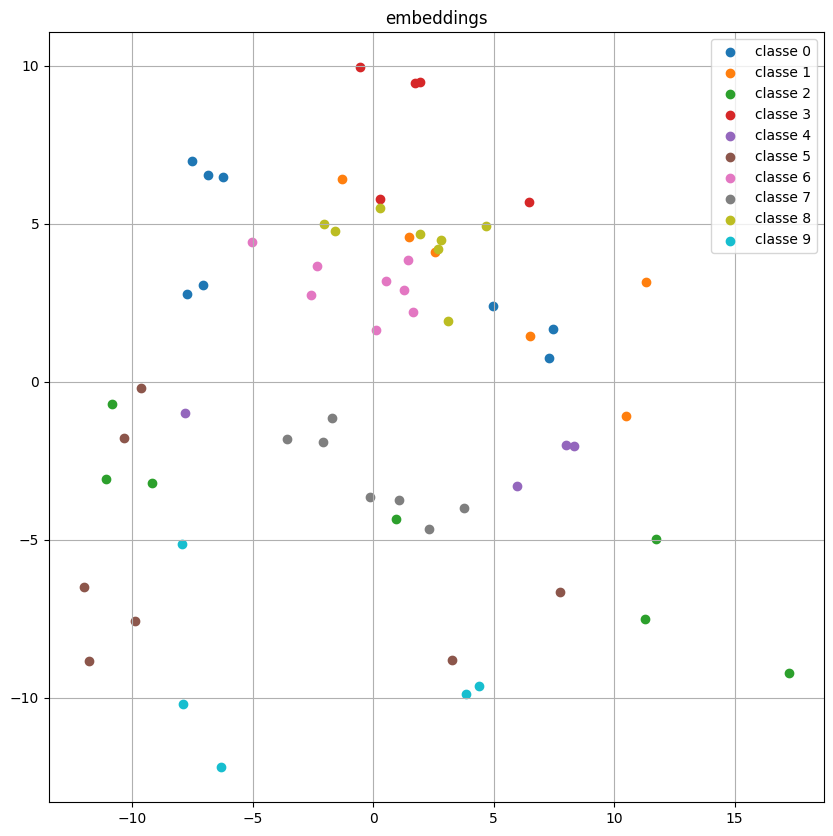

In [46]:
autoencoder.eval()
embeddings = []
avg_embeddings = []
with torch.no_grad():
    for images, labels in train_loader:
        #print(labels)
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        emb, output,_,_ = autoencoder(images)

        for i in range(emb.size(0)):
            embeddings.append([emb[i].cpu().tolist(), labels[i].cpu().item()])

    emb_np = np.array([item[0] for item in embeddings])
    lab_np = np.array([item[1] for item in embeddings])



    for cls in range(nb_classes):
        idx = np.where(lab_np == cls)[0]
        avg_emb = emb_np[idx].mean(axis=0)

        avg_embeddings.append(avg_emb)

        print(f"classe {cls}: avg embedding = {avg_emb.tolist()}")

def plot_embeddings():
    embeddings_np = np.array([e[0] for e in embeddings])
    labels_np = np.array([e[1] for e in embeddings])

    pca = PCA(n_components=2) #reduction en 2D
    reduced_embeddings = pca.fit_transform(embeddings_np)

    plt.figure(figsize=(10, 10))
    for label in np.unique(labels_np):
        idx = labels_np == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"classe {label}")

    plt.title("embeddings")
    plt.legend()
    plt.grid(True)
    plt.show()



plot_embeddings()

#### Decoder

#### Sur jeu d'entrainement

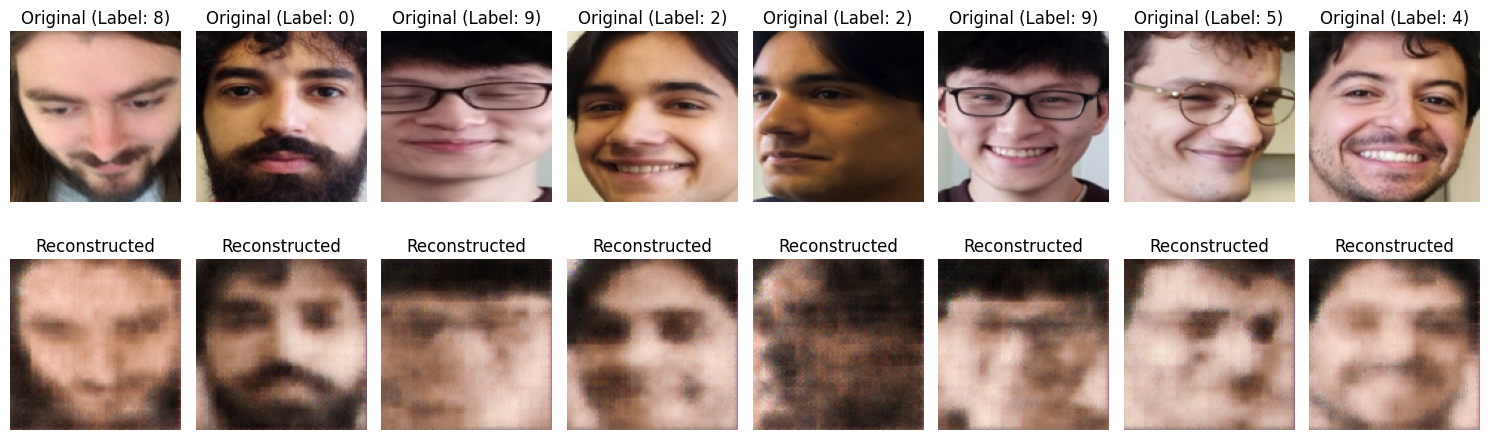

In [47]:
autoencoder.eval()

images, labels = next(iter(train_loader))
images = images.to(device)

with torch.no_grad():

    _,reconstructed_images, _,_ = autoencoder(images)


n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[1, i].imshow(recon_disp)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

#### Sur jeu de test

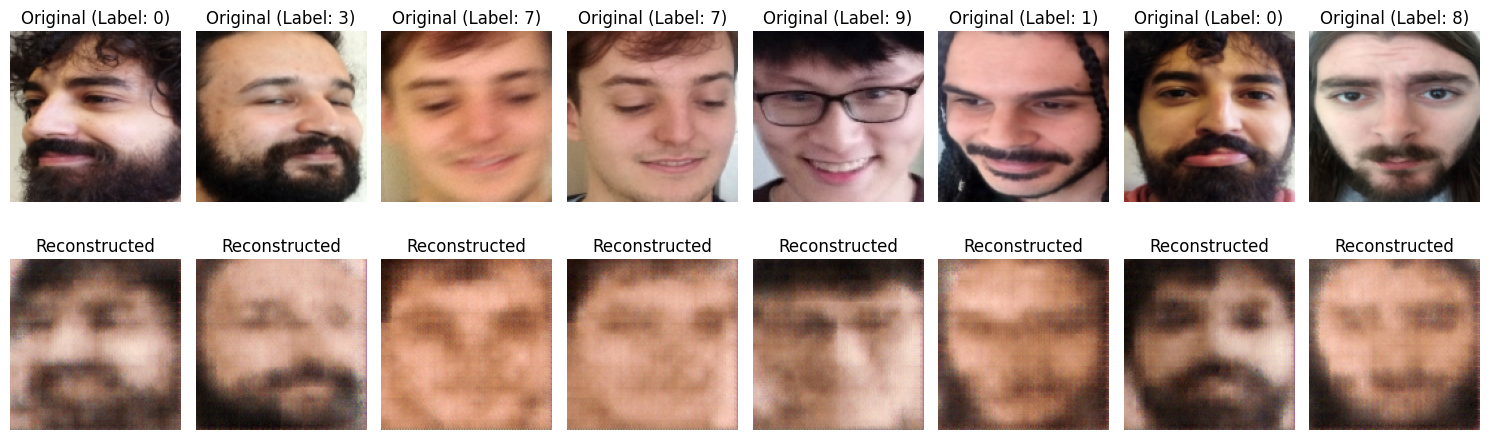

In [48]:
autoencoder.eval()

images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    _,reconstructed_images,_,_ = autoencoder(images)


n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[1, i].imshow(recon_disp)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

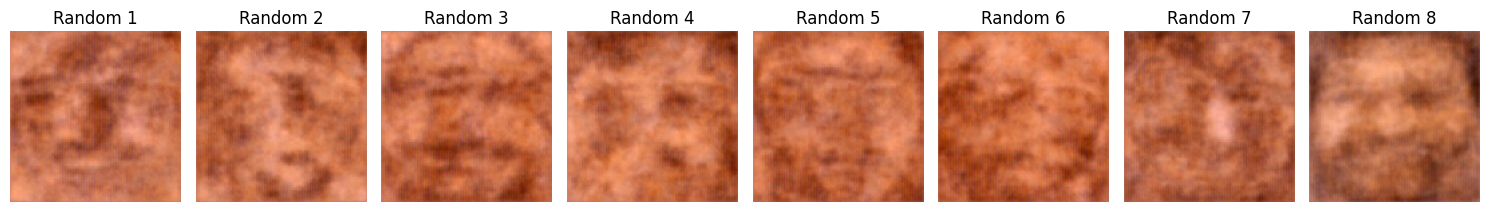

In [30]:
autoencoder.eval()

reconstructed_images = []

with torch.no_grad():
    for _ in range(8):
        _, img = autoencoder.random()
        reconstructed_images.append(img)

reconstructed_images = torch.cat(reconstructed_images, dim=0)

n = reconstructed_images.size(0)
fig, axs = plt.subplots(1, n, figsize=(15, 5))

for i in range(n):
    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[i].imshow(recon_disp)
    axs[i].axis("off")
    axs[i].set_title(f"Random {i+1}")

plt.tight_layout()
plt.show()


In [ ]:
autoencoder.eval()

random_embeddings = torch.tensor(avg_embeddings, device=device, dtype=torch.float32)

random_embeddings = random_embeddings.to(device)

decoder_only = autoencoder.decoder.eval()

with torch.no_grad():
    #un = random_embeddings.unflatten(1, (EMBEDDING_SIZE, 1, 1))
    #generated_images = autoencoder.decoder(random_embeddings)

    h = autoencoder.fc_decode(random_embeddings)
    h = h.view(-1, autoencoder.max_feature, autoencoder.img_size, autoencoder.img_size)
    generated_images = autoencoder.decoder(h)
    

n = generated_images.size(0)
fig, axs = plt.subplots(1, n, figsize=(15, 5))

for i in range(n):
    img = generated_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[i].imshow(img_disp)
    axs[i].axis("off")
    axs[i].set_title(f"class {i+1}")

plt.tight_layout()
plt.show()

#### HYPER LOOP

In [ ]:
from itertools import product

learning_rates = [0.0001, 0.001]
betas = [0.5, 1.0, 2.0]
lpips_factors = [0.0]
batch_sizes = [4,8,16, 32]
weight_decays = [0.0]
latent_sizes = [32,64,128]
epochs = 250

total_models = len(learning_rates) * len(betas) * len(lpips_factors) * len(batch_sizes) * len(weight_decays) * len(latent_sizes)
i = 0

for lr, beta, lpips_factor, batch_size, weight_decay, latent_s in product(learning_rates, betas, lpips_factors, batch_sizes, weight_decays, latent_sizes):
    #print(f"Training VAE with lr={lr}, beta={beta}, lpips_factor={lpips_factor}, batch_size={batch_size}, weight_decay={weight_decay}")
    
    autoencoder = VAE(latent_s).to(device)

    optimizer = optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    def elbo_loss(recon, x, mean, logvar):
        recon_loss = (F.l1_loss(recon, x, reduction='sum') / x.size(0)) #+ lpipsLoss(recon, x).mean() * lpips_factor
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / x.size(0)
        return recon_loss + beta * kl_loss, recon_loss, beta * kl_loss

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        autoencoder.train()
        total_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)

            optimizer.zero_grad()
            z, recon, mean, logvar = autoencoder(images)
            loss, recon_loss, kl_loss = elbo_loss(recon, images, mean, logvar)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        scheduler.step()
        #print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

    model_name = f"models/vae_lr{lr}_beta{beta}_lpips{lpips_factor}_bs{batch_size}_ls{latent_s}.pth"
    torch.save(autoencoder.state_dict(), model_name)
    print(f"model saved {model_name} ")
    
    print(f"{i}/{total_models}")
    i+=1

In [ ]:
import re

model_dir = "models"
model_files = [f for f in os.listdir(model_dir) if f.endswith(".pth")]

for model_file in model_files:
    print(f"testing model: {model_file}")
    
    latent_size_match = re.search(r'_ls(\d+)', model_file)
    if latent_size_match:
        latent_size = int(latent_size_match.group(1))
    else:
        print(f"Could not extract latent size from filename: {model_file}")
        continue
    
    autoencoder = VAE(embedding=latent_size).to(device)
    model_path = os.path.join(model_dir, model_file)
    autoencoder.load_state_dict(torch.load(model_path))
    autoencoder.eval()
    
    total_loss = 0.0
    reconstructed_images = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            _, recon, mean, logvar = autoencoder(images)
            loss, _, _ = elbo_loss(recon, images, mean, logvar)
            total_loss += loss.item()
            reconstructed_images.append(recon.cpu())
    
    avg_loss = total_loss / len(test_loader)
    print(f"avg loss on test set: {avg_loss:.4f}")
    
    reconstructed_images = torch.cat(reconstructed_images, dim=0)
    n = min(8, reconstructed_images.size(0))
    fig, axs = plt.subplots(2, n, figsize=(15, 5))
    
    for i in range(n):
        original_img = images[i].permute(1, 2, 0).cpu().numpy()
        recon_img = reconstructed_images[i].permute(1, 2, 0).numpy()
        
        mi, ma = original_img.min(), original_img.max()
        original_disp = (original_img - mi) / (ma - mi) if ma - mi > 1e-6 else original_img
        
        mi, ma = recon_img.min(), recon_img.max()
        recon_disp = (recon_img - mi) / (ma - mi) if ma - ma > 1e-6 else recon_img
        
        axs[0, i].imshow(original_disp)
        axs[0, i].set_title("Original")
        axs[0, i].axis("off")
        
        axs[1, i].imshow(recon_disp)
        axs[1, i].set_title("Reconstructed")
        axs[1, i].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    del autoencoder
    torch.cuda.empty_cache()


##     Entrainement du decodeur uniquement avec un embedder deja entraine

In [ ]:
decoder = Decoder().to(device)
L1loss = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.0001)

final_classifier_loss = [0.0,0.0]

losses = []

faceEmbedder.eval()
for epoch in range(100):
    total_loss = 0.0
    decoder.train()
    for images, labels in train_loader:
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)
        #print(images.size())

        output = decoder(embeded)
        #print(output.size())

        loss = L1loss(output, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    #test avec le set de validation
    decoder.eval()
    total_eval_loss = 0.0
    for images, labels in test_loader:
        #images = torch.flatten(images, 1)
        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = decoder(embeded)
        loss = L1loss(output, images)

        #metrics
        total_eval_loss += loss.item()


    total_loss = total_loss / len(train_loader)
    total_eval_loss = total_eval_loss / len(test_loader)
    print(f"Epoch {epoch+1}, training loss: {total_loss:.4f}, test loss: {total_eval_loss:.4f}")

    losses.append((total_loss, total_eval_loss))

    final_classifier_loss[0] = total_loss
    final_classifier_loss[1] = total_eval_loss



### Analyse

In [ ]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

In [ ]:
decoder.eval()
faceEmbedder.eval()

images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    embeddings = faceEmbedder(images)

    reconstructed_images = decoder(embeddings)


n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[1, i].imshow(recon_disp)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

### Reconstruction de la moyenne des embeddings de chaque classe

In [ ]:
decoder.eval()

random_embeddings = torch.tensor(avg_embeddings, device=device)

random_embeddings = random_embeddings.to(device)

with torch.no_grad():
    generated_images = decoder(random_embeddings)

n = generated_images.size(0)
fig, axs = plt.subplots(1, n, figsize=(15, 5))

for i in range(n):
    img = generated_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[i].imshow(img_disp)
    axs[i].axis("off")
    axs[i].set_title(f"Generated {i+1}")

plt.tight_layout()
plt.show()